# TP5 - VpC1
### Andrés Merli

- Implementar el detector de fondo naive usando la mediana como
estimador. El algoritmo debe recibir el parámetro N (cantidad de
frames utilizados para la estimación) y el intervalo de tiempo para
recalcular el fondo.
- Se deben generar las mascaras de foreground y aplicarlas a los frames
para segmentar los objetos en movimiento.
- Comparar con alguno de los métodos vistos en la practica basados en
mezcla de gaussianas

In [1]:
#%matplotlib inline  

import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt
import time

In [6]:
# verificamos función para obtener cantidad de frames
capture.get(cv.CAP_PROP_FRAME_COUNT)

914.0

#### Código que calcula el background a partir de la mediana de una grupo N aleatorio de frames

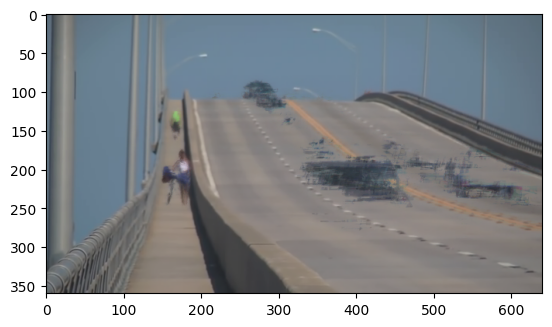

-1

In [2]:
#filename = 'vtest.avi'
filename = 'slow_traffic_small.mp4'
capture = cv.VideoCapture(filename)

n_frames = 30
frames_list = []

if not capture.isOpened:
    print('Falla al abrir el archivo: ' + filename)
    exit(0)

# Seleccionamos n_frames de forma aleatoria

random_list = random.sample(range(int(capture.get(cv.CAP_PROP_FRAME_COUNT))), n_frames)
#frameIds = capture.get(cv.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=50)

# guardamos n_frames en un array para calcular la mediana

for n in random_list:
    capture.set(cv.CAP_PROP_POS_FRAMES, n)
    ret, frame = capture.read()
    frames_list.append(frame)
frames_array = np.array(frames_list)

# Calculamos la mediana del grupo de n_frames
background_model = np.median(frames_array, axis=0).astype(dtype=np.uint8) 

# Mostramos simplemente el modelo de fondo creado por pantalla y en la notebook

plt.imshow(cv.cvtColor(background_model, cv.COLOR_BGR2RGB))
plt.show()

cv.imshow('frame', background_model)
cv.waitKey()



#### Generamos las máscaras y aplicamos a los frames para segementar los objetos en movimiento

In [3]:
# Reseteamos el numero de frame
capture.set(cv.CAP_PROP_POS_FRAMES, 0)

# Corremos la sustraccion
#------------------------

while True:
    # Leemos un frame
    ret, frame = capture.read()
    if frame is None:
        break
    
    #Convertimos a escala de grises
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    background_model_gray = cv.cvtColor(background_model, cv.COLOR_BGR2GRAY)

    # Aplicamos la sustracción del background al frame leído
    #----------------------------------------
    foreground = cv.absdiff(frame_gray, background_model_gray)
    
    #Aplicamos binarización
    ret, fgMask = cv.threshold(foreground,40,255,cv.THRESH_BINARY)
        
    # Escribimos sobre la imagen el número de frame procesado
    cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
               cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    
    # mostramos frame original e imagen binaria background/foreground
    cv.imshow('Frame', frame)
    cv.imshow('FG Mask', fgMask)
    
    # Corresmos hasta que termine o apriete escape
    keyboard = cv.waitKey(30)
    if keyboard == 'q' or keyboard == 27:
        break

cv.destroyAllWindows()
capture.release()


### Funciona!

### Ahora Creamos la función que tome los parámetros de n_frames y tiempo de recalculo

In [4]:
def sustraccion_fondo_medianas(filename, n_frames, delta_time):
    
    capture = cv.VideoCapture(filename)
    frames_list = []

    if not capture.isOpened:
        print('Falla al abrir el archivo: ' + filename)
        exit(0)

    # Seleccionamos n_frames de forma aleatoria
    random_list = random.sample(range(int(capture.get(cv.CAP_PROP_FRAME_COUNT))), n_frames)
    
    #Variables de control del tiempo
    delta_time_acum = 0
    timestamp = 0
    
    # guardamos n_frames en un array para calcular la mediana
    for n in random_list:
        capture.set(cv.CAP_PROP_POS_FRAMES, n)
        ret, frame = capture.read()
        frames_list.append(frame)
    
    frames_array = np.array(frames_list)
    
    # Calculamos la mediana del grupo de n_frames
    background_model = np.median(frames_array, axis=0).astype(dtype=np.uint8) 
    
    # Reseteamos el numero de frame
    capture.set(cv.CAP_PROP_POS_FRAMES, 0)
    
    # Corremos la sustraccion
    #------------------------
    
    while True:
        
        timestamp = time.time()
        # Leemos un frame
        ret, frame = capture.read()
        if frame is None:
            break
        
        #Verificamos si hay que actualizar el background
        if delta_time_acum >= delta_time:
            print(delta_time_acum)
            next_frame = capture.get(cv.CAP_PROP_POS_FRAMES)
            # guardamos n_frames en un array para calcular la mediana
            for n in random_list:
                capture.set(cv.CAP_PROP_POS_FRAMES, n)
                ret, frame = capture.read()
                frames_list.append(frame)
            
            frames_array = np.array(frames_list)
            # Calculamos la mediana del grupo de n_frames
            background_model = np.median(frames_array, axis=0).astype(dtype=np.uint8)
            capture.set(cv.CAP_PROP_POS_FRAMES, next_frame)
            delta_time_acum = 0
        
        
        #Convertimos a escala de grises
        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        background_model_gray = cv.cvtColor(background_model, cv.COLOR_BGR2GRAY)

        # Aplicamos la sustracción del background al frame leído
        #----------------------------------------
        foreground = cv.absdiff(frame_gray, background_model_gray)
        
        #Aplicamos binarización
        ret, fgMask = cv.threshold(foreground,40,255,cv.THRESH_BINARY)
            
        # Escribimos sobre la imagen el número de frame procesado
        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
                cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
        
        # mostramos frame original e imagen binaria background/foreground
        cv.imshow('Frame', frame)
        cv.imshow('FG Mask', fgMask)
        
        print(timestamp)
        print(time.time())
        delta_time_acum += (time.time() - timestamp)
        print(delta_time_acum)
        
        # Corresmos hasta que termine o apriete escape
        keyboard = cv.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break

    cv.destroyAllWindows()
    capture.release()
    


#### No me quedó funcionando el recalculo del background a cada intervalo delta de tiempo, tengo algún error en el calculo del tiempo transcurrido y acumulado

In [5]:
sustraccion_fondo_medianas(filename, 30, 10)

1670973622.3116317
1670973622.3375633
0.025931596755981445
1670973622.3704991
1670973622.3714724
0.026904821395874023
1670973622.4173486
1670973622.4173486
0.026904821395874023
1670973622.4492877
1670973622.4502614
0.027878522872924805
1670973622.481475
1670973622.481475
0.027878522872924805
1670973622.527304
1670973622.527304
0.027878522872924805
1670973622.5726254
1670973622.5726254
0.027878522872924805
1670973622.6191754
1670973622.6211684
0.029871463775634766
1670973622.6662014
1670973622.6681972
0.031867265701293945
1670973622.7124841
1670973622.714447
0.03383016586303711
1670973622.7583914
1670973622.761363
0.036801815032958984
1670973622.8052406
1670973622.8072064
0.03876757621765137
1670973622.8529837
1670973622.8539848
0.03976869583129883
1670973622.8991084
1670973622.9001088
0.040769100189208984
1670973622.9453475
1670973622.9473383
0.04275989532470703
1670973622.9930177
1670973622.9970155
0.04675769805908203
1670973623.0393226
1670973623.0412934
0.04872846603393555
167097362